# YouTube Comment Cleaning and Exploration

Takes data from a CSV file and cleans the data to isolate comments of interest

In [1]:
import re
import japanize_matplotlib
import matplotlib.pyplot as plt
import nagisa
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter
from functools import reduce
from operator import add
from pathlib import Path

NumExpr defaulting to 8 threads.


In [2]:
input_path = Path('Resources/youtube_comments.csv')
comments_df = pd.read_csv(input_path, index_col=0)

comments_df.head(10)

channel     video_id  category_id  \
0  mwamjapan  Jb6Zlg30rgk           10   
1  mwamjapan  Jb6Zlg30rgk           10   
2  mwamjapan  Jb6Zlg30rgk           10   
3  mwamjapan  Jb6Zlg30rgk           10   
4  mwamjapan  Jb6Zlg30rgk           10   
5  mwamjapan  Jb6Zlg30rgk           10   
6  mwamjapan  Jb6Zlg30rgk           10   
7  mwamjapan  Jb6Zlg30rgk           10   
8  mwamjapan  Jb6Zlg30rgk           10   
9  mwamjapan  Jb6Zlg30rgk           10   

                                                text        date_published  \
0        This season is going to be a masterpiece <3  2023-04-16T15:39:10Z   
1                    Every season is masterpiece üî•üî•üî•  2023-04-17T16:41:52Z   
2                                   @HM cry about it  2023-04-17T16:15:19Z   
3  @HM dude demon slayer has no story but it has ...  2023-04-17T15:44:29Z   
4                                          @HM üôÇüôÉüòíüòíüòí  2023-04-17T13:44:05Z   
5  Honestamente no entiendo porqu√© esta canci√≥n r...  2023-04-17T03:58:25Z   
6                           ‚Äã@„Åø„Å£„Åè„ÇììàíìÇÇ‚óåùôºùô∏ùöàùöÑ llora pues  2023-04-17T17:15:35Z   
7                          „Åü„Åã„ÅåOP„Åß‰∏ñÁïåË¶≥„ÅåÂ£ä„Çå„Çã„Ç¢„Éã„É°„Åò„ÇÉ„Å™„ÅÑ„Çè„ÅØ„Åí„Åü„Åì  2023-04-17T16:00:09Z   
8                                            ÊÇ©„ÇÅ„Å∞„ÄÅ„Ç§„Ç§ÔºÅ  2023-04-17T14:53:19Z   
9                          @„Åø„Å£„Åè„ÇììàíìÇÇ‚óåùôºùô∏ùöàùöÑ „Éã„ÉØ„Ç´„Åª„Å©„Åù„ÅÜË®Ä„ÅÜ„Çà„Å≠ÔºÅ  2023-04-17T13:11:13Z   

  comment_type  
0    top-level  
1        reply  
2        reply  
3        reply  
4        reply  
5    top-level  
6        reply  
7        reply  
8        reply  
9        reply

In [3]:
# RE patterns needed for JP text
hiragana = r'\u3041-\u3096'
katakana = r'\u30A1-\u30F6'
kanji = r'\u3006\u4E00-\u9FFF'

# Matches to test for existence of text that uses a Japanese script
jp_text = rf'[{hiragana}{katakana}{kanji}]'

# Accepted characters
accepted_char = rf'[a-zA-Z0-9\u30FC\u3005{hiragana}{katakana}{kanji}]'

In [4]:
# Remove @username from replies
# Done before rest of cleaning to ensure a user using a Japanese script doesn't pass filter
comments_df['text'] = comments_df['text'].str.replace(r'@\S+\s', '', regex=True)

In [5]:
# Filter out comments that don't have any Japanese characters
has_jp_char = comments_df.loc[comments_df['text'].str.contains(jp_text, regex=True)]

has_jp_char.sample(10)

channel     video_id  category_id  \
33                   Pekora Ch. ÂÖéÁî∞„Å∫„Åì„Çâ  JOFXeA2h3tY           20   
71                          QuizKnock  OY85Fp2gTQE           24   
49                     Kuzuha Channel  NwF8wYFaZCE           20   
17                    eFootball „ÉÅ„É£„É≥„Éç„É´  JIZ_5BTM43Y           17   
9                         ÂÜÖÂ±±È´òÂøóKO„ÉÅ„É£„É≥„Éç„É´  yxSTX86YziI           22   
46                      ‰∏°Â≠¶Èï∑ „É™„Éô„É©„É´„Ç¢„Éº„ÉÑÂ§ßÂ≠¶  nHFJD7WOLMs           24   
30                  KAI Channel / ÊúùÂÄâÊµ∑  frMtfMxTVT4           24   
148                            Êù±Êµ∑„Ç™„É≥„Ç®„Ç¢  Vd0ShQDUops           23   
84          SUPER GT Official Channel  4fx_0IRdvSc           17   
48   Leo the football TV from „Ç∑„É•„ÉØ„Éº„ÉúÊù±‰∫¨  X5Yz86aBDYs           17   

                                                  text        date_published  \
33   „Åø„Çì„Å™Á∑¥Áøí„Åã„ÇâÂáÑ„ÅÑÈ†ëÂºµ„Å£„Å¶„Åü„ÅóÂ§ß‰ºöÊú¨Áï™„ÇÇÂêçÂãùË≤†„Å∞„Åã„Çä„Åß„ÇÅ„Å°„ÇÉ„ÇÅ„Å°„ÇÉÁôΩÁÜ±„Åó„ÅüÔºÅ„Éû„É™„É≥ËàπÈï∑ÂÑ™Âãù„Åä...  2023-04-16T15:02:59Z   
71                      „ÇØ„Ç§„Ç∫„Éé„ÉÉ„ÇØ„ÅØ‰ΩúÂïè„Åå„ÇÅ„Å°„ÇÉ„Åè„Å°„ÇÉÂáù„Å£„Å¶„Çã„Åã„Çâ„Åô„Åî„ÅÑÊ•Ω„Åó„ÇÅ„Çã‚Ä¶  2023-04-11T12:49:35Z   
49   ‰ªä„Åæ„ÅßÊ≤¢Â±±4‰∫∫„Åß‰ΩïË©¶Âêà„ÇÇ„Åó„Å¶„Ç≥„Éü„É•„Éã„Ç±„Éº„Ç∑„Éß„É≥Âèñ„Å£„Å¶„ÄÅË©¶Ë°åÈåØË™§„Åó„Å¶ÊúÄÂçî„Åß„ÅôÔºÅÔºÅÔºÅÊú¨Áï™Á≤æ‰∏ÄÊùØÊ•Ω...  2023-04-15T07:55:08Z   
17                          „Åì„Åì„Åæ„Åß„Ç´„É≥„ÉÜ„Å†„Å£„Åü„Åë„Å©‰ªäÂõû„É°„ÉÉ„Ç∑„ÅÆÁâáÈ±óË¶ã„Åõ„Å¶„Åç„Å¶Ëçâ  2023-04-16T12:54:54Z   
9                  ÂÜÖÂ±±„Åï„Çì„ÅØ„ÄÅÊú¨ÂΩì„Å´„Çè„Åã„Çä„ÇÑ„Åô„ÅÑ„Åó„ÄÅÁÜ±„ÅÑ„Åó„ÄÅ„Éú„ÇØ„Ç∑„É≥„Ç∞„Å∏„ÅÆÊÄù„ÅÑ„Åå‰ºù„Çè„Çã„ÄÇ  2023-04-09T23:45:07Z   
46   „ÄåÁµ∂ÂØæ„Å´Áõ≤‰ø°„Åô„Çã„Å™„Äç\n„Å®„ÄÅÂè£ÈÖ∏„Å£„Å±„ÅèË®Ä„Å£„Å¶„Åè„Çå„Çã„ÄÇ\n„Éõ„É≥„Éà„Å´„Åù„ÅÆÈÄö„Çä„Åü„Åë„Å©„ÄÅ\nÂ≠¶Èï∑„Åï„Çì...  2023-04-13T01:50:00Z   
30   Â•≥Â≠ê„ÅØÈÅ∏ËÄÉ„Åã„Çâ.5„Åã„Çâ„Å™„Å´„Åã„Çâ„Åì„ÅÆ„ÉÅ„É£„É≥„Éç„É´„Å®Èô∏Êñó„Åè„Çì„ÅÆ„ÉÅ„É£„É≥„Éç„É´„ÅßÊµÅ„Åó„Å¶„ÇÇ„Çâ„Åä„ÅÜ\nË≤¢ÁåÆ„É¨...  2023-04-13T11:19:55Z   
148                                  „ÇÑ„Å∞„ÅÑ„Åä„Å´„Åé„ÇäÈ£ü„Åπ„Åü„Åè„Å™„Å£„Å¶„Åç„Åüüçô  2023-04-14T02:09:26Z   
84                                         „É¢„ÉÅ„É•„Éº„É´„Åä„ÇÅ„Åß„Å®„ÅÜüéâ  2023-04-16T09:41:06Z   
48        ÂØæË´á„ÅØ„ÇÇ„Å°„Çç„Çì„ÄÅ‰ªäÂæå„ÅÆ‰∫§ÂèãÈñ¢‰øÇ„ÇÇËâØ„Åè„Å™„Å£„Å¶Ê¨≤„Åó„ÅÑ„Åß„Åô„Å≠„ÄÇÈÖí‰∫ïÂÆèÊ®π„Åï„Çì„ÄÅ„Åª„Çì„Å®„Å´„ÇØ„É¨„Éê„Éº„ÄÇ  2023-04-16T13:11:27Z   

    comment_type  
33     top-level  
71     top-level  
49     top-level  
17         reply  
9      top-level  
46     top-level  
30     top-level  
148    top-level  
84     top-level  
48     top-level

In [6]:
# Remove other unnecessary characters - 
def clean_text(text):
    
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\t', '', text)
    text = re.sub(r'\r', '', text)
    text = re.sub(r'https?://[a-zA-Z0-9.-]*[/?[a-zA-Z0-9.-_]*]*', '', text)
    text = re.sub(r'Á¨ë+', 'Á¨ë', text)
    
    filtered_text = ''
    
    for char in text:
        if re.match(accepted_char, char):
            
            filtered_text += char
            
    return filtered_text

In [7]:
# Clean
cleaned_df = has_jp_char.copy()
cleaned_df['text'] = cleaned_df['text'].apply(clean_text)

cleaned_df.head(10)

channel     video_id  category_id  \
7   mwamjapan  Jb6Zlg30rgk           10   
8   mwamjapan  Jb6Zlg30rgk           10   
9   mwamjapan  Jb6Zlg30rgk           10   
18  mwamjapan  Jb6Zlg30rgk           10   
19  mwamjapan  Jb6Zlg30rgk           10   
44  mwamjapan  Jb6Zlg30rgk           10   
45  mwamjapan  Jb6Zlg30rgk           10   
46  mwamjapan  Jb6Zlg30rgk           10   
47  mwamjapan  Jb6Zlg30rgk           10   
48  mwamjapan  Jb6Zlg30rgk           10   

                                                 text        date_published  \
7                           „Åü„Åã„ÅåOP„Åß‰∏ñÁïåË¶≥„ÅåÂ£ä„Çå„Çã„Ç¢„Éã„É°„Åò„ÇÉ„Å™„ÅÑ„Çè„ÅØ„Åí„Åü„Åì  2023-04-17T16:00:09Z   
8                                               ÊÇ©„ÇÅ„Å∞„Ç§„Ç§  2023-04-17T14:53:19Z   
9                                         „Éã„ÉØ„Ç´„Åª„Å©„Åù„ÅÜË®Ä„ÅÜ„Çà„Å≠  2023-04-17T13:11:13Z   
18                               Áèç„Åó„Åè„Ç∑„Éß„Éº„ÉàÂãïÁîª„ÅåÂá∫„Å¶„Åæ„Åô„Å≠ÊúÄÈ´ò„Åô„Åé„Çã  2023-04-17T10:49:06Z   
19                                             „ÇÅ„Å£„Å°„ÇÉÂêåÊÑè  2023-04-17T08:30:39Z   
44  milet„Å®„ÅÆ„Ç≥„É©„Éú„Å´„ÅØÊúÄÂàù„Å≥„Å£„Åè„Çä„Åó„Åü„Åë„Å©Â£∞„ÅÆÁõ∏ÊÄß„ÅåËâØ„Åè„Å¶Áâπ„Å´Èáç„Å™„Å£„ÅüÊôÇ„Å´‰Ωï„Å®„ÇÇË®Ä„Åà„Å™„ÅÑ‰∏ç...  2023-04-17T00:54:46Z   
45  ÂÖ®„Åè‰ª∞„Çã„Å®„Åä„Çä„Åß‰Ωú‰∏≠„Å´„ÅØ„ÅÑ„Çç„Çì„Å™ÁµÜ„ÉéÂ•áË∑°„Åå„ÅÇ„Çä„Åæ„Åô„Çà„Å≠Áâπ„Å´ÂàÄÈçõÂÜ∂„ÅÆÈáåÁ∑®„ÅÆ„É©„Çπ„Éà„ÅØÁµÜ„ÉéÂ•áË∑°„Åù„ÅÆ...  2023-04-17T13:48:13Z   
46  Êàë„ÅåÂëΩÊûú„Å¶„Çà„ÅÜ„Å®„ÇÇÁπã„ÅÑ„Åß„ÅÑ„Åì„ÅÜËá™ÂàÜ„ÅåÂøóÂçä„Å∞„ÅßÊ≠ª„Çì„Åß„ÇÇÁπã„ÅÑ„Å†ÂëΩ„Åå„Åç„Å£„Å®Êûú„Åü„Åó„Å¶„Åè„Çå„Çã„Å®‰∫åË©±„ÅßÁÇ≠...  2023-04-17T13:37:24Z   
47                            Êàë„ÅåÂëΩÊûú„Å¶„Çà„ÅÜ„Å®„ÇÇ„Å´„ÅØÁÑ°‰∏ÄÈÉé„ÇíÊÄù„ÅÑÊµÆ„Åã„Åπ„Åæ„Åó„Åü  2023-04-17T13:07:22Z   
48                                È¨ºÊªÖ„ÅÆÂàÉ„Å´„ÅØËâ≤„Çì„Å™ÁµÜ„ÉéÂ•áË∑°„Åå„ÅÇ„Çä„Åæ„Åô„Å≠  2023-04-17T11:53:14Z   

   comment_type  
7         reply  
8         reply  
9         reply  
18        reply  
19        reply  
44    top-level  
45        reply  
46        reply  
47        reply  
48        reply

In [8]:
# Check size of DF
cleaned_df.shape

(11297, 6)

In [9]:
# Check for null values
cleaned_df.isna().sum()

channel           0
video_id          0
category_id       0
text              0
date_published    0
comment_type      0
dtype: int64

In [10]:
# Check unique values in each
cleaned_df.nunique()

channel              82
video_id             92
category_id          12
text              10659
date_published    11104
comment_type          2
dtype: int64

In [11]:
# Check amounts of top-level vs. replies for comments
cleaned_df['comment_type'].value_counts()

top-level    8320
reply        2977
Name: comment_type, dtype: int64

In [12]:
# Tokenize text
analysis_df = cleaned_df.copy()
analysis_df['tokens'] = analysis_df['text'].apply(lambda x: nagisa.tagging(x))

analysis_df.head(10)

channel     video_id  category_id  \
7   mwamjapan  Jb6Zlg30rgk           10   
8   mwamjapan  Jb6Zlg30rgk           10   
9   mwamjapan  Jb6Zlg30rgk           10   
18  mwamjapan  Jb6Zlg30rgk           10   
19  mwamjapan  Jb6Zlg30rgk           10   
44  mwamjapan  Jb6Zlg30rgk           10   
45  mwamjapan  Jb6Zlg30rgk           10   
46  mwamjapan  Jb6Zlg30rgk           10   
47  mwamjapan  Jb6Zlg30rgk           10   
48  mwamjapan  Jb6Zlg30rgk           10   

                                                 text        date_published  \
7                           „Åü„Åã„ÅåOP„Åß‰∏ñÁïåË¶≥„ÅåÂ£ä„Çå„Çã„Ç¢„Éã„É°„Åò„ÇÉ„Å™„ÅÑ„Çè„ÅØ„Åí„Åü„Åì  2023-04-17T16:00:09Z   
8                                               ÊÇ©„ÇÅ„Å∞„Ç§„Ç§  2023-04-17T14:53:19Z   
9                                         „Éã„ÉØ„Ç´„Åª„Å©„Åù„ÅÜË®Ä„ÅÜ„Çà„Å≠  2023-04-17T13:11:13Z   
18                               Áèç„Åó„Åè„Ç∑„Éß„Éº„ÉàÂãïÁîª„ÅåÂá∫„Å¶„Åæ„Åô„Å≠ÊúÄÈ´ò„Åô„Åé„Çã  2023-04-17T10:49:06Z   
19                                             „ÇÅ„Å£„Å°„ÇÉÂêåÊÑè  2023-04-17T08:30:39Z   
44  milet„Å®„ÅÆ„Ç≥„É©„Éú„Å´„ÅØÊúÄÂàù„Å≥„Å£„Åè„Çä„Åó„Åü„Åë„Å©Â£∞„ÅÆÁõ∏ÊÄß„ÅåËâØ„Åè„Å¶Áâπ„Å´Èáç„Å™„Å£„ÅüÊôÇ„Å´‰Ωï„Å®„ÇÇË®Ä„Åà„Å™„ÅÑ‰∏ç...  2023-04-17T00:54:46Z   
45  ÂÖ®„Åè‰ª∞„Çã„Å®„Åä„Çä„Åß‰Ωú‰∏≠„Å´„ÅØ„ÅÑ„Çç„Çì„Å™ÁµÜ„ÉéÂ•áË∑°„Åå„ÅÇ„Çä„Åæ„Åô„Çà„Å≠Áâπ„Å´ÂàÄÈçõÂÜ∂„ÅÆÈáåÁ∑®„ÅÆ„É©„Çπ„Éà„ÅØÁµÜ„ÉéÂ•áË∑°„Åù„ÅÆ...  2023-04-17T13:48:13Z   
46  Êàë„ÅåÂëΩÊûú„Å¶„Çà„ÅÜ„Å®„ÇÇÁπã„ÅÑ„Åß„ÅÑ„Åì„ÅÜËá™ÂàÜ„ÅåÂøóÂçä„Å∞„ÅßÊ≠ª„Çì„Åß„ÇÇÁπã„ÅÑ„Å†ÂëΩ„Åå„Åç„Å£„Å®Êûú„Åü„Åó„Å¶„Åè„Çå„Çã„Å®‰∫åË©±„ÅßÁÇ≠...  2023-04-17T13:37:24Z   
47                            Êàë„ÅåÂëΩÊûú„Å¶„Çà„ÅÜ„Å®„ÇÇ„Å´„ÅØÁÑ°‰∏ÄÈÉé„ÇíÊÄù„ÅÑÊµÆ„Åã„Åπ„Åæ„Åó„Åü  2023-04-17T13:07:22Z   
48                                È¨ºÊªÖ„ÅÆÂàÉ„Å´„ÅØËâ≤„Çì„Å™ÁµÜ„ÉéÂ•áË∑°„Åå„ÅÇ„Çä„Åæ„Åô„Å≠  2023-04-17T11:53:14Z   

   comment_type                                             tokens  
7         reply  „Åü„Åã/ÂêçË©û „Åå/Âä©Ë©û OP/ÂêçË©û „Åß/Âä©Ë©û ‰∏ñÁïå/ÂêçË©û Ë¶≥/Êé•Â∞æËæû „Åå/Âä©Ë©û Â£ä„Çå„Çã/ÂãïË©û ...  
8         reply                                  ÊÇ©„ÇÅ/ÂãïË©û „Å∞/Âä©Ë©û „Ç§„Ç§/ÂΩ¢ÂÆπË©û  
9         reply                „Éã„ÉØ„Ç´/ÂΩ¢Áä∂Ë©û „Åª„Å©/Âä©Ë©û „Åù„ÅÜ/ÂâØË©û Ë®Ä„ÅÜ/ÂãïË©û „Çà/Âä©Ë©û „Å≠/Âä©Ë©û  
18        reply  Áèç„Åó„Åè/ÂΩ¢ÂÆπË©û „Ç∑„Éß„Éº„Éà/ÂêçË©û ÂãïÁîª/ÂêçË©û „Åå/Âä©Ë©û Âá∫/ÂãïË©û „Å¶/Âä©ÂãïË©û „Åæ„Åô/Âä©ÂãïË©û „Å≠...  
19        reply                                      „ÇÅ„Å£„Å°„ÇÉ/ÂâØË©û ÂêåÊÑè/ÂêçË©û  
44    top-level  milet/ÂêçË©û „Å®/Âä©Ë©û „ÅÆ/Âä©Ë©û „Ç≥„É©„Éú/ÂêçË©û „Å´/Âä©Ë©û „ÅØ/Âä©Ë©û ÊúÄÂàù/ÂêçË©û „Å≥„Å£„Åè„Çä...  
45        reply  ÂÖ®„Åè/ÂâØË©û ‰ª∞„Çã/ÂãïË©û „Å®„Åä„Çä/ÂêçË©û „Åß/Âä©Ë©û ‰Ωú‰∏≠/ÂêçË©û „Å´/Âä©Ë©û „ÅØ/Âä©Ë©û „ÅÑ„Çç„Çì„Å™/ÈÄ£...  
46        reply  Êàë„Åå/ÈÄ£‰ΩìË©û ÂëΩ/ÂêçË©û Êûú„Å¶„Çà„ÅÜ/ÂãïË©û „Å®/Âä©Ë©û „ÇÇ/Âä©Ë©û Áπã„ÅÑ/ÂãïË©û „Åß/Âä©Ë©û „ÅÑ„Åì„ÅÜ/Âãï...  
47        reply  Êàë„Åå/ÈÄ£‰ΩìË©û ÂëΩ/ÂêçË©û Êûú„Å¶„Çà„ÅÜ/ÂãïË©û „Å®„ÇÇ/ÂêçË©û „Å´/Âä©Ë©û „ÅØ/Âä©Ë©û ÁÑ°‰∏ÄÈÉé/ÂêçË©û „Çí/Âä©...  
48        reply  È¨ºÊªÖ/ÂêçË©û „ÅÆ/Âä©Ë©û ÂàÉ/ÂêçË©û „Å´/Âä©Ë©û „ÅØ/Âä©Ë©û Ëâ≤„Çì„Å™/ÈÄ£‰ΩìË©û ÁµÜ„Éé/ÂêçË©û Â•áË∑°/ÂêçË©û ...

In [56]:
# Created filtered column
analysis_df['filtered_tokens'] = (analysis_df['text']
                                  .apply(lambda x: nagisa.filter(x, filter_postags=['Âä©Ë©û', 'Âä©ÂãïË©û', '„É≠„Éº„ÉûÂ≠óÊñá',
                                                                                    'Êú™Áü•Ë™û', 'URL'])))

analysis_df.head(10)

channel     video_id  category_id  \
7   mwamjapan  Jb6Zlg30rgk           10   
8   mwamjapan  Jb6Zlg30rgk           10   
9   mwamjapan  Jb6Zlg30rgk           10   
18  mwamjapan  Jb6Zlg30rgk           10   
19  mwamjapan  Jb6Zlg30rgk           10   
44  mwamjapan  Jb6Zlg30rgk           10   
45  mwamjapan  Jb6Zlg30rgk           10   
46  mwamjapan  Jb6Zlg30rgk           10   
47  mwamjapan  Jb6Zlg30rgk           10   
48  mwamjapan  Jb6Zlg30rgk           10   

                                                 text        date_published  \
7                           „Åü„Åã„ÅåOP„Åß‰∏ñÁïåË¶≥„ÅåÂ£ä„Çå„Çã„Ç¢„Éã„É°„Åò„ÇÉ„Å™„ÅÑ„Çè„ÅØ„Åí„Åü„Åì  2023-04-17T16:00:09Z   
8                                               ÊÇ©„ÇÅ„Å∞„Ç§„Ç§  2023-04-17T14:53:19Z   
9                                         „Éã„ÉØ„Ç´„Åª„Å©„Åù„ÅÜË®Ä„ÅÜ„Çà„Å≠  2023-04-17T13:11:13Z   
18                               Áèç„Åó„Åè„Ç∑„Éß„Éº„ÉàÂãïÁîª„ÅåÂá∫„Å¶„Åæ„Åô„Å≠ÊúÄÈ´ò„Åô„Åé„Çã  2023-04-17T10:49:06Z   
19                                             „ÇÅ„Å£„Å°„ÇÉÂêåÊÑè  2023-04-17T08:30:39Z   
44  milet„Å®„ÅÆ„Ç≥„É©„Éú„Å´„ÅØÊúÄÂàù„Å≥„Å£„Åè„Çä„Åó„Åü„Åë„Å©Â£∞„ÅÆÁõ∏ÊÄß„ÅåËâØ„Åè„Å¶Áâπ„Å´Èáç„Å™„Å£„ÅüÊôÇ„Å´‰Ωï„Å®„ÇÇË®Ä„Åà„Å™„ÅÑ‰∏ç...  2023-04-17T00:54:46Z   
45  ÂÖ®„Åè‰ª∞„Çã„Å®„Åä„Çä„Åß‰Ωú‰∏≠„Å´„ÅØ„ÅÑ„Çç„Çì„Å™ÁµÜ„ÉéÂ•áË∑°„Åå„ÅÇ„Çä„Åæ„Åô„Çà„Å≠Áâπ„Å´ÂàÄÈçõÂÜ∂„ÅÆÈáåÁ∑®„ÅÆ„É©„Çπ„Éà„ÅØÁµÜ„ÉéÂ•áË∑°„Åù„ÅÆ...  2023-04-17T13:48:13Z   
46  Êàë„ÅåÂëΩÊûú„Å¶„Çà„ÅÜ„Å®„ÇÇÁπã„ÅÑ„Åß„ÅÑ„Åì„ÅÜËá™ÂàÜ„ÅåÂøóÂçä„Å∞„ÅßÊ≠ª„Çì„Åß„ÇÇÁπã„ÅÑ„Å†ÂëΩ„Åå„Åç„Å£„Å®Êûú„Åü„Åó„Å¶„Åè„Çå„Çã„Å®‰∫åË©±„ÅßÁÇ≠...  2023-04-17T13:37:24Z   
47                            Êàë„ÅåÂëΩÊûú„Å¶„Çà„ÅÜ„Å®„ÇÇ„Å´„ÅØÁÑ°‰∏ÄÈÉé„ÇíÊÄù„ÅÑÊµÆ„Åã„Åπ„Åæ„Åó„Åü  2023-04-17T13:07:22Z   
48                                È¨ºÊªÖ„ÅÆÂàÉ„Å´„ÅØËâ≤„Çì„Å™ÁµÜ„ÉéÂ•áË∑°„Åå„ÅÇ„Çä„Åæ„Åô„Å≠  2023-04-17T11:53:14Z   

   comment_type                                             tokens  \
7         reply  „Åü„Åã/ÂêçË©û „Åå/Âä©Ë©û OP/ÂêçË©û „Åß/Âä©Ë©û ‰∏ñÁïå/ÂêçË©û Ë¶≥/Êé•Â∞æËæû „Åå/Âä©Ë©û Â£ä„Çå„Çã/ÂãïË©û ...   
8         reply                                  ÊÇ©„ÇÅ/ÂãïË©û „Å∞/Âä©Ë©û „Ç§„Ç§/ÂΩ¢ÂÆπË©û   
9         reply                „Éã„ÉØ„Ç´/ÂΩ¢Áä∂Ë©û „Åª„Å©/Âä©Ë©û „Åù„ÅÜ/ÂâØË©û Ë®Ä„ÅÜ/ÂãïË©û „Çà/Âä©Ë©û „Å≠/Âä©Ë©û   
18        reply  Áèç„Åó„Åè/ÂΩ¢ÂÆπË©û „Ç∑„Éß„Éº„Éà/ÂêçË©û ÂãïÁîª/ÂêçË©û „Åå/Âä©Ë©û Âá∫/ÂãïË©û „Å¶/Âä©ÂãïË©û „Åæ„Åô/Âä©ÂãïË©û „Å≠...   
19        reply                                      „ÇÅ„Å£„Å°„ÇÉ/ÂâØË©û ÂêåÊÑè/ÂêçË©û   
44    top-level  milet/ÂêçË©û „Å®/Âä©Ë©û „ÅÆ/Âä©Ë©û „Ç≥„É©„Éú/ÂêçË©û „Å´/Âä©Ë©û „ÅØ/Âä©Ë©û ÊúÄÂàù/ÂêçË©û „Å≥„Å£„Åè„Çä...   
45        reply  ÂÖ®„Åè/ÂâØË©û ‰ª∞„Çã/ÂãïË©û „Å®„Åä„Çä/ÂêçË©û „Åß/Âä©Ë©û ‰Ωú‰∏≠/ÂêçË©û „Å´/Âä©Ë©û „ÅØ/Âä©Ë©û „ÅÑ„Çç„Çì„Å™/ÈÄ£...   
46        reply  Êàë„Åå/ÈÄ£‰ΩìË©û ÂëΩ/ÂêçË©û Êûú„Å¶„Çà„ÅÜ/ÂãïË©û „Å®/Âä©Ë©û „ÇÇ/Âä©Ë©û Áπã„ÅÑ/ÂãïË©û „Åß/Âä©Ë©û „ÅÑ„Åì„ÅÜ/Âãï...   
47        reply  Êàë„Åå/ÈÄ£‰ΩìË©û ÂëΩ/ÂêçË©û Êûú„Å¶„Çà„ÅÜ/ÂãïË©û „Å®„ÇÇ/ÂêçË©û „Å´/Âä©Ë©û „ÅØ/Âä©Ë©û ÁÑ°‰∏ÄÈÉé/ÂêçË©û „Çí/Âä©...   
48        reply  È¨ºÊªÖ/ÂêçË©û „ÅÆ/Âä©Ë©û ÂàÉ/ÂêçË©û „Å´/Âä©Ë©û „ÅØ/Âä©Ë©û Ëâ≤„Çì„Å™/ÈÄ£‰ΩìË©û ÁµÜ„Éé/ÂêçË©û Â•áË∑°/ÂêçË©û ...   

                                      filtered_tokens  
7   „Åü„Åã/ÂêçË©û OP/ÂêçË©û ‰∏ñÁïå/ÂêçË©û Ë¶≥/Êé•Â∞æËæû Â£ä„Çå„Çã/ÂãïË©û „Ç¢„Éã„É°/ÂêçË©û „Å™„ÅÑ/ÂΩ¢ÂÆπË©û „ÅØ...  
8                                        ÊÇ©„ÇÅ/ÂãïË©û „Ç§„Ç§/ÂΩ¢ÂÆπË©û  
9                                 „Éã„ÉØ„Ç´/ÂΩ¢Áä∂Ë©û „Åù„ÅÜ/ÂâØË©û Ë®Ä„ÅÜ/ÂãïË©û  
18            Áèç„Åó„Åè/ÂΩ¢ÂÆπË©û „Ç∑„Éß„Éº„Éà/ÂêçË©û ÂãïÁîª/ÂêçË©û Âá∫/ÂãïË©û ÊúÄÈ´ò/ÂêçË©û „Åô„Åé„Çã/ÂãïË©û  
19                                      „ÇÅ„Å£„Å°„ÇÉ/ÂâØË©û ÂêåÊÑè/ÂêçË©û  
44  milet/ÂêçË©û „Ç≥„É©„Éú/ÂêçË©û ÊúÄÂàù/ÂêçË©û „Å≥„Å£„Åè„Çä/ÂêçË©û „Åó/ÂãïË©û Â£∞/ÂêçË©û Áõ∏ÊÄß/ÂêçË©û ...  
45  ÂÖ®„Åè/ÂâØË©û ‰ª∞„Çã/ÂãïË©û „Å®„Åä„Çä/ÂêçË©û ‰Ωú‰∏≠/ÂêçË©û „ÅÑ„Çç„Çì„Å™/ÈÄ£‰ΩìË©û ÁµÜ„Éé/ÂêçË©û Â•áË∑°/ÂêçË©û ...  
46  Êàë„Åå/ÈÄ£‰ΩìË©û ÂëΩ/ÂêçË©û Êûú„Å¶„Çà„ÅÜ/ÂãïË©û Áπã„ÅÑ/ÂãïË©û „ÅÑ„Åì„ÅÜ/ÂãïË©û Ëá™ÂàÜ/ÂêçË©û Âøó/ÂêçË©û Âçä„Å∞...  
47          Êàë„Åå/ÈÄ£‰ΩìË©û Âë

In [57]:
# Use for examining properties of the tokens
test = analysis_df.iloc[0]['filtered_tokens']
test

In [58]:
test.words

['„Åü„Åã', 'OP', '‰∏ñÁïå', 'Ë¶≥', 'Â£ä„Çå„Çã', '„Ç¢„Éã„É°', '„Å™„ÅÑ', '„ÅØ„Åí', '„Åü„Åì']

In [59]:
type(test.words[0])

str

In [60]:
str(test)

'„Åü„Åã/ÂêçË©û OP/ÂêçË©û ‰∏ñÁïå/ÂêçË©û Ë¶≥/Êé•Â∞æËæû Â£ä„Çå„Çã/ÂãïË©û „Ç¢„Éã„É°/ÂêçË©û „Å™„ÅÑ/ÂΩ¢ÂÆπË©û „ÅØ„Åí/ÂêçË©û „Åü„Åì/ÂêçË©û'

In [61]:
# Extract filtered_tokens into a list
def extract_tokens(df_column):

    token_list = df_column.apply(lambda x: str(x).split()).tolist()
    word_list = reduce(add, token_list)
    
    return word_list

word_list = extract_tokens(analysis_df['filtered_tokens'])

In [62]:
# Get total word count and examine sample of the list
total_words = len(word_list)
print(total_words, word_list[:10])

163957 ['„Åü„Åã/ÂêçË©û', 'OP/ÂêçË©û', '‰∏ñÁïå/ÂêçË©û', 'Ë¶≥/Êé•Â∞æËæû', 'Â£ä„Çå„Çã/ÂãïË©û', '„Ç¢„Éã„É°/ÂêçË©û', '„Å™„ÅÑ/ÂΩ¢ÂÆπË©û', '„ÅØ„Åí/ÂêçË©û', '„Åü„Åì/ÂêçË©û', 'ÊÇ©„ÇÅ/ÂãïË©û']


In [63]:
# Count and sort by occurrences
def count_words(word_list):
    
    counter = Counter(word_list)
    freq_list = counter.most_common()
    
    return freq_list

In [87]:
# Organize data as a DF display
def display_freq(freq_list):
    
    freq_df = pd.DataFrame.from_records(list(dict(freq_list).items()),
                                        columns=['word', 'count'])
    freq_df[['word', 'pos']] = freq_df['word'].str.split('/', expand=True)
    freq_df = freq_df[['word', 'pos', 'count']]
    
    # Remove entries that are only numbers
    freq_df = freq_df.loc[~freq_df['word'].str.contains('\d+')].reset_index(drop=True)
    
    return freq_df

## Frequency for entire dataset

Outside of particles, auxiliary verbs and roman digits the count of all unique words is considered - including very common words like „Åô„Çã as well as internet colloquialisms such as w (indicates laughter similar to "lol").
Data is sorted into the most common words for the dataset in descending order. 

In [65]:
# Calculating totals for entire dataset
freq_list = count_words(word_list)
freq_df = display_freq(freq_list)

freq_df.head(25)

word  pos  count
0    „Åó   ÂãïË©û   3578
1    1   ÂêçË©û   2347
2   „Åï„Çì  Êé•Â∞æËæû   2149
3    0   ÂêçË©û   2094
4    2   ÂêçË©û   1848
5    3   ÂêçË©û   1492
6    „Åä  Êé•È†≠Ëæû   1439
7    5   ÂêçË©û   1255
8    4   ÂêçË©û   1204
9  „Å°„ÇÉ„Çì  Êé•Â∞æËæû   1182

In [67]:
freq_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17501 entries, 0 to 17500
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   word    17501 non-null  object
 1   pos     17501 non-null  object
 2   count   17501 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 410.3+ KB


In [68]:
def get_percentages(freq_df):
    
    total_words = sum(freq_df['count'])
    freq_df['freq_percentage'] = freq_df['count'] / total_words
    
    return freq_df

In [69]:
freq_df = get_percentages(freq_df)

freq_df.head(25)

word  pos  count  freq_percentage
0       „Åó   ÂãïË©û   3578         0.023616
1      „Åï„Çì  Êé•Â∞æËæû   2149         0.014184
2       „Åä  Êé•È†≠Ëæû   1439         0.009498
3     „Å°„ÇÉ„Çì  Êé•Â∞æËæû   1182         0.007802
4       Ë¶ã   ÂãïË©û   1096         0.007234
5      „Åì„ÅÆ  ÈÄ£‰ΩìË©û    844         0.005571
6   „ÅÇ„Çä„Åå„Å®„ÅÜ  ÊÑüÂãïË©û    813         0.005366
7      „ÅÑ„ÅÑ  ÂΩ¢ÂÆπË©û    796         0.005254
8      Â•Ω„Åç  ÂΩ¢Áä∂Ë©û    788         0.005201
9      „Å™„ÅÑ  ÂΩ¢ÂÆπË©û    786         0.005188
10      „ÅÑ   ÂãïË©û    784         0.005175
11     ÊúÄÈ´ò   ÂêçË©û    761         0.005023
12     „Åô„Çã   ÂãïË©û    736         0.004858
13    „Åô„Åé„Çã   ÂãïË©û    730         0.004818
14     „Åì„Å®   ÂêçË©û    728         0.004805
15    „Åî„Åñ„ÅÑ   ÂãïË©û    650         0.004290
16     „Å™„Å£   ÂãïË©û    638         0.004211
17      w   Ë®òÂè∑    632         0.004171
18     Êú¨ÂΩì   ÂêçË©û    622         0.004105
19     „ÅÑ„Çã   ÂãïË©û    602         0.003973
20     „Åì„Çå  ‰ª£ÂêçË©û    598         0.003947
21     ÂãïÁîª   ÂêçË©û    584         0.003855
22     „ÅÇ„Çã   ÂãïË©û    583         0.003848
23      ‰∫∫   ÂêçË©û    557         0.003676
24      „Åï   ÂãïË©û    519         0.003426

In [70]:
# Summary stats
freq_df.describe()

count  freq_percentage
count  17501.000000     17501.000000
mean       8.657048         0.000057
std       50.041541         0.000330
min        1.000000         0.000007
25%        1.000000         0.000007
50%        1.000000         0.000007
75%        4.000000         0.000026
max     3578.000000         0.023616

In [71]:
# Examine breakdown of each POS
parts_of_speech = freq_df.groupby('pos').agg(
    unique_terms = ('word', 'count'),
    total = ('count', 'sum'),
    percent = ('freq_percentage', 'sum'))

# Sort the result
parts_of_speech = (parts_of_speech.reset_index()
                       .sort_values(['total'], ascending=False)
                       .set_index(['pos']))

parts_of_speech

unique_terms  total   percent
pos                                 
ÂêçË©û            11099  72227  0.476724
ÂãïË©û             3299  35547  0.234623
ÂΩ¢ÂÆπË©û             625  10643  0.070248
Êé•Â∞æËæû             385   9980  0.065872
ÂâØË©û              580   6560  0.043298
ÂΩ¢Áä∂Ë©û             414   5406  0.035682
‰ª£ÂêçË©û              84   3420  0.022573
Êé•È†≠Ëæû              83   2468  0.016290
ÈÄ£‰ΩìË©û              33   1854  0.012237
ÊÑüÂãïË©û              67   1103  0.007280
webË™§ËÑ±           693    990  0.006534
Ë®òÂè∑               55    744  0.004911
Êé•Á∂öË©û              22    281  0.001855
Ë£úÂä©Ë®òÂè∑             49    270  0.001782
Ëã±ÂçòË™û              13     14  0.000092

### Plotting frequency

Uses multiple bar charts using subplots to visualize top 100 most used words - idea and code is adapted from Boriharn K from Towards Data Science

In [72]:
def plot_frequency_bars(freq_df, title):
    # Split DF into 5 equal sections
    # And make a list of the start and end indices for each subsection
    index_list = [[i[0], i[-1] + 1] for i in np.array_split(range(100), 5)]
    max_val, min_val = freq_df['count'].max(), freq_df.iloc[99]['count']

    fig, axs = plt.subplots(1, 5, figsize=(16, 8))
    fig.suptitle(title, fontsize=16)
    sns.set(font='IPAexGothic')

    # Create a dictionary for color mappings
    scaled_count = freq_df.iloc[0:99]['count'] // min_val
    pal = list(sns.color_palette(palette='crest',
                                 n_colors=scaled_count.max()).as_hex())
    color_dict = dict(enumerate(pal, 1))

    for col, i in enumerate(index_list):
        df = freq_df.iloc[i[0]:i[-1]]
        label = [f'{word}:{count}' for word, count in zip(df['word'], df['count'])]
        colors = [color_dict.get(val // min_val) for val in df['count']]
        x = list(df['count'])
        y = list(range(20))

        sns.barplot(x=x, y=y, alpha=0.9, orient='h',
                   ax=axs[col], palette=colors)
        axs[col].set_xlim(0, max_val + 1)
        axs[col].set_yticklabels(label, fontsize=12)

    plt.tight_layout()
    plt.show()

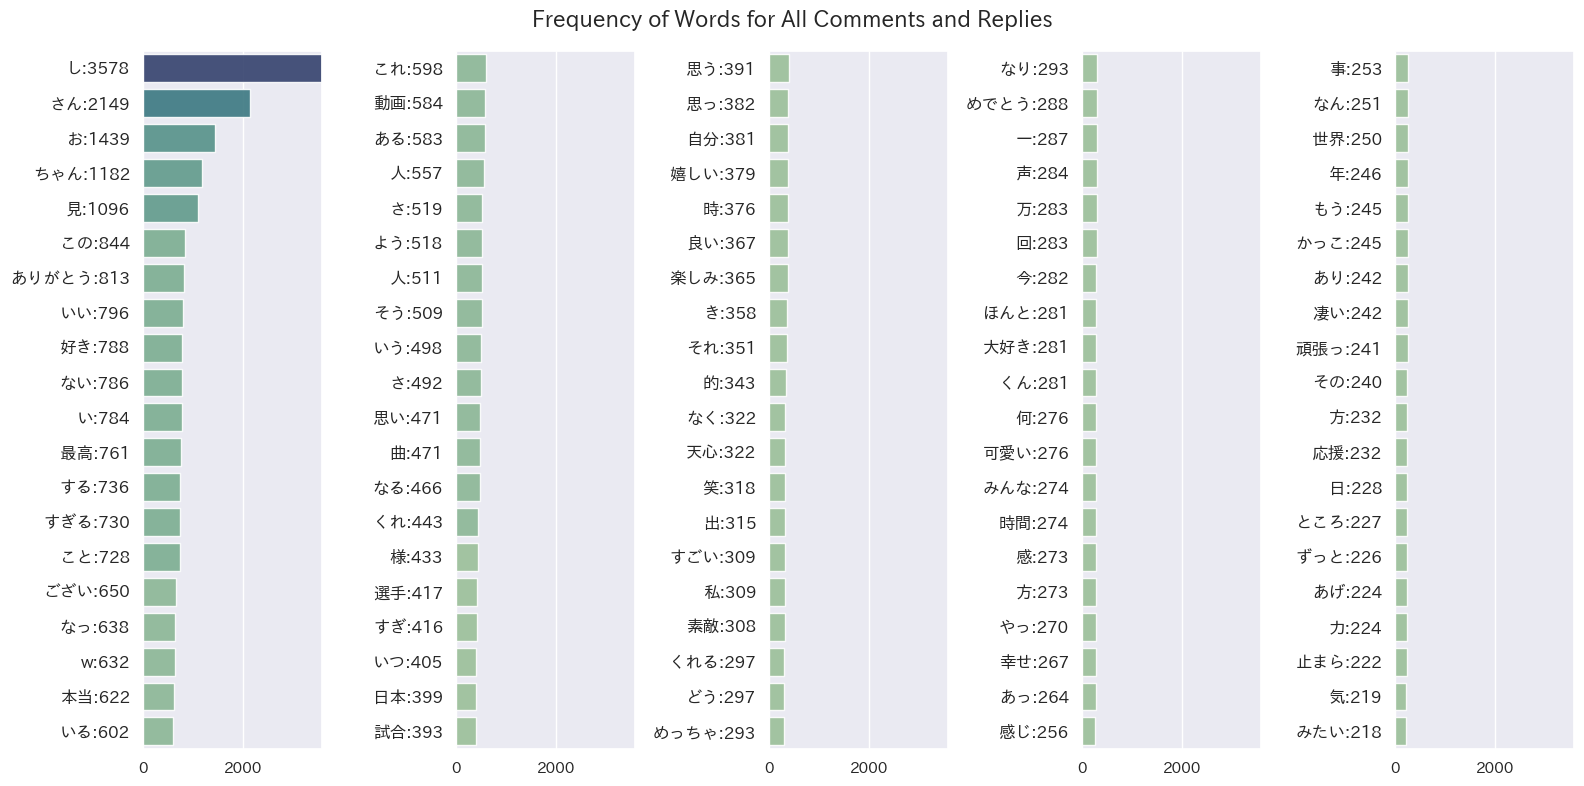

In [73]:
# All YouTube comments
plot_frequency_bars(freq_df, 'Frequency of Words for All Comments and Replies')

## Frequency by Comment Type

### Top-level YouTube Comments
Can have replies associated with them, but can also not.

In [84]:
# Filter for top-level comments only
top_level_df = analysis_df.loc[analysis_df['comment_type'] == 'top-level']

print(top_level_df.shape)
top_level_df.head()

(8320, 8)


channel     video_id  category_id  \
44  mwamjapan  Jb6Zlg30rgk           10   
51  mwamjapan  Jb6Zlg30rgk           10   
58  mwamjapan  Jb6Zlg30rgk           10   
69  mwamjapan  Jb6Zlg30rgk           10   
71  mwamjapan  Jb6Zlg30rgk           10   

                                                 text        date_published  \
44  milet„Å®„ÅÆ„Ç≥„É©„Éú„Å´„ÅØÊúÄÂàù„Å≥„Å£„Åè„Çä„Åó„Åü„Åë„Å©Â£∞„ÅÆÁõ∏ÊÄß„ÅåËâØ„Åè„Å¶Áâπ„Å´Èáç„Å™„Å£„ÅüÊôÇ„Å´‰Ωï„Å®„ÇÇË®Ä„Åà„Å™„ÅÑ‰∏ç...  2023-04-17T00:54:46Z   
51  Ê≠åË©ûÈóáÂ§ú„ÇíÈßÜ„ÅëÊäú„Åë„Å¶‰ΩïÂá¶„Å∏„ÇÄ„Åã„ÅÜÊúàÊòé„Åã„Çä„Å†„Åë„Åå„Åü„Å†‰∏Ä„Å§„ÅÆÈÅìÊ®ôÁóõ„Åø„ÇÇÊÇ≤„Åó„Åø„ÇÇÊã≠„ÅÑ„Åç„Çå„Åö„Åï„Çå„Å©„Åì...  2023-04-17T00:43:46Z   
58  Ê≠åË©û„Åß„ÅôÈóáÂ§ú„ÇíÈßÜ„ÅëÊäú„Åë„Å¶‰ΩïÂá¶„Å∏„ÇÄ„Åã„ÅÜÊúàÊòé„Åã„Çä„Å†„Åë„Åå„Åü„Å†‰∏Ä„Å§„ÅÆÈÅìÊ®ôÁóõ„Åø„ÇÇÊÇ≤„Åó„Åø„ÇÇÊã≠„ÅÑ„Åç„Çå„Åö„Åï„Çå...  2023-04-17T08:10:12Z   
69  ÈÅéÂéª„ÅÆOP„Åå„Åã„Å™„ÇäËâØ„Åã„Å£„Åü„Åã„ÇâÊØî„Åπ„Çâ„Çå„Å¶„ÇÇ‰ªïÊñπ„Å™„ÅÑ„ÅÆ„Å´‰ªäÂõû„ÇÇÊúÄÈ´ò„Å†„Åã„ÇâÊØî„Åπ„Çà„ÅÜ„Åå„Å™„ÅÑ„Å©„ÅÆOP...  2023-04-17T10:00:33Z   
71  manwith„Åï„Çì„Å®milet„Åï„Çì„ÅÆmv„ÅØÂ§ßÂçä„ÇØ„Éº„É´„Å™Ëã±Ë™ûÊ≠åË©û„Åß„ÅÇ„Çã„ÅÆ„Å´ÂØæ„Åó„Å¶„Åì„ÅÆ„Ç≥„É©„Éú‰ΩúÂìÅ...  2023-04-17T13:41:28Z   

   comment_type                                             tokens  \
44    top-level  milet/ÂêçË©û „Å®/Âä©Ë©û „ÅÆ/Âä©Ë©û „Ç≥„É©„Éú/ÂêçË©û „Å´/Âä©Ë©û „ÅØ/Âä©Ë©û ÊúÄÂàù/ÂêçË©û „Å≥„Å£„Åè„Çä...   
51    top-level  Ê≠åË©û/ÂêçË©û Èóá/ÂêçË©û Â§ú/ÂêçË©û „Çí/Âä©Ë©û ÈßÜ„ÅëÊäú„Åë/ÂãïË©û „Å¶/Âä©Ë©û ‰ΩïÂá¶/‰ª£ÂêçË©û „Å∏/Âä©Ë©û ...   
58    top-level  Ê≠åË©û/ÂêçË©û „Åß„Åô/Âä©ÂãïË©û ÈóáÂ§ú/ÂêçË©û „Çí/Âä©Ë©û ÈßÜ„ÅëÊäú„Åë/ÂãïË©û „Å¶/Âä©Ë©û ‰ΩïÂá¶/‰ª£ÂêçË©û „Å∏/...   
69    top-level  ÈÅéÂéª/ÂêçË©û „ÅÆ/Âä©Ë©û OP/ÂêçË©û „Åå/Âä©Ë©û „Åã„Å™„Çä/ÂâØË©û ËâØ„Åã„Å£/ÂΩ¢ÂÆπË©û „Åü/Âä©ÂãïË©û „Åã„Çâ/...   
71    top-level  manwith/ÂêçË©û „Åï„Çì/Êé•Â∞æËæû „Å®/Âä©Ë©û milet/ÂêçË©û „Åï„Çì/Êé•Â∞æËæû „ÅÆ/Âä©Ë©û mv...   

                                      filtered_tokens  
44  milet/ÂêçË©û „Ç≥„É©„Éú/ÂêçË©û ÊúÄÂàù/ÂêçË©û „Å≥„Å£„Åè„Çä/ÂêçË©û „Åó/ÂãïË©û Â£∞/ÂêçË©û Áõ∏ÊÄß/ÂêçË©û ...  
51  Ê≠åË©û/ÂêçË©û Èóá/ÂêçË©û Â§ú/ÂêçË©û ÈßÜ„ÅëÊäú„Åë/ÂãïË©û ‰ΩïÂá¶/‰ª£ÂêçË©û „ÇÄ„Åã„ÅÜ/ÂãïË©û ÊúàÊòé„Åã„Çä/ÂêçË©û ...  
58  Ê≠åË©û/ÂêçË©û ÈóáÂ§ú/ÂêçË©û ÈßÜ„ÅëÊäú„Åë/ÂãïË©û ‰ΩïÂá¶/‰ª£ÂêçË©û „ÇÄ„Åã„ÅÜ/ÂãïË©û ÊúàÊòé„Åã„Çä/ÂêçË©û „Åü„Å†/ÂâØ...  
69  ÈÅéÂéª/ÂêçË©û OP/ÂêçË©û „Åã„Å™„Çä/ÂâØË©û ËâØ„Åã„Å£/ÂΩ¢ÂÆπË©û ÊØî„Åπ/ÂãïË©û ‰ªïÊñπ„Å™„ÅÑ/ÂΩ¢ÂÆπË©û ‰ªäÂõû/Âêç...  
71  manwith/ÂêçË©û „Åï„Çì/Êé•Â∞æËæû milet/ÂêçË©û „Åï„Çì/Êé•Â∞æËæû mv/ÂêçË©û Â§ßÂçä/ÂêçË©û ...

In [88]:
# Extract the filtered tokens into a list
word_list = extract_tokens(top_level_df['filtered_tokens'])

In [90]:
# Count unique words and create a frequency DF
freq_list = count_words(word_list)
freq_df = display_freq(freq_list)
freq_df = get_percentages(freq_df)

freq_df.head(25)

word  pos  count  freq_percentage
0       „Åó   ÂãïË©û   2981         0.023711
1      „Åï„Çì  Êé•Â∞æËæû   2002         0.015924
2       „Åä  Êé•È†≠Ëæû   1355         0.010778
3     „Å°„ÇÉ„Çì  Êé•Â∞æËæû    938         0.007461
4       Ë¶ã   ÂãïË©û    783         0.006228
5      „Åì„ÅÆ  ÈÄ£‰ΩìË©û    746         0.005934
6      Â•Ω„Åç  ÂΩ¢Áä∂Ë©û    732         0.005822
7   „ÅÇ„Çä„Åå„Å®„ÅÜ  ÊÑüÂãïË©û    726         0.005775
8       „ÅÑ   ÂãïË©û    695         0.005528
9      „ÅÑ„ÅÑ  ÂΩ¢ÂÆπË©û    678         0.005393
10     ÊúÄÈ´ò   ÂêçË©û    669         0.005321
11    „Åô„Åé„Çã   ÂãïË©û    638         0.005075
12     „Åô„Çã   ÂãïË©û    620         0.004932
13     „Åì„Å®   ÂêçË©û    597         0.004749
14     Êú¨ÂΩì   ÂêçË©û    589         0.004685
15    „Åî„Åñ„ÅÑ   ÂãïË©û    579         0.004605
16     „Å™„ÅÑ  ÂΩ¢ÂÆπË©û    542         0.004311
17     „Å™„Å£   ÂãïË©û    539         0.004287
18     „Åì„Çå  ‰ª£ÂêçË©û    523         0.004160
19     „ÅÑ„Çã   ÂãïË©û    477         0.003794
20     ÂãïÁîª   ÂêçË©û    469         0.003730
21      ‰∫∫  Êé•Â∞æËæû    468         0.003723
22     „ÅÇ„Çã   ÂãïË©û    462         0.003675
23      „Åï  Êé•Â∞æËæû    448         0.003563
24     „Åù„ÅÜ  ÂΩ¢Áä∂Ë©û    446         0.003548

In [91]:
# Get summary stats
freq_df.describe()

count  freq_percentage
count  15260.000000     15260.000000
mean       8.238598         0.000066
std       45.646877         0.000363
min        1.000000         0.000008
25%        1.000000         0.000008
50%        1.000000         0.000008
75%        4.000000         0.000032
max     2981.000000         0.023711

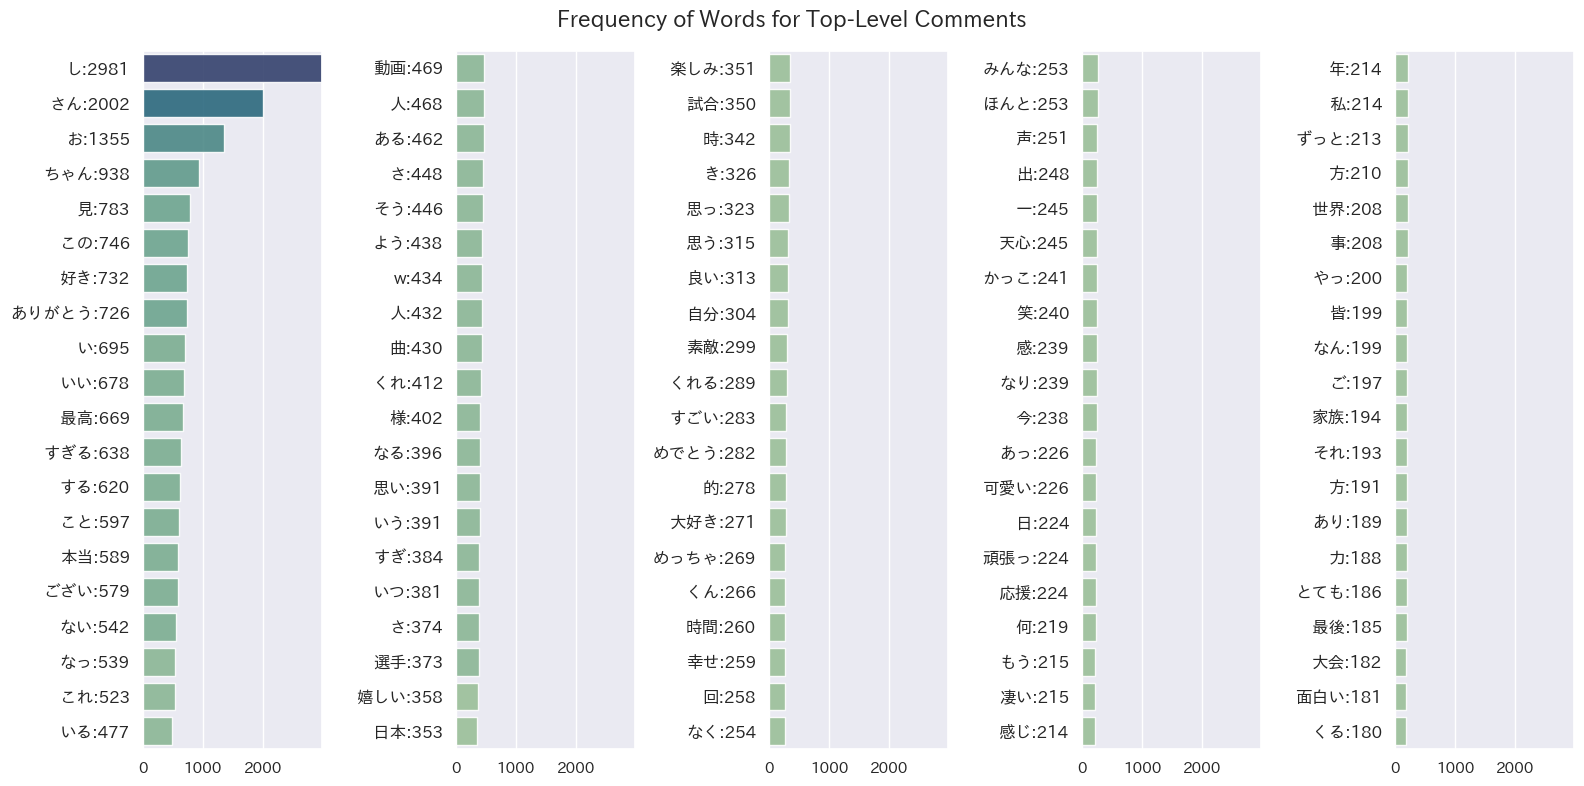

In [92]:
# Generate bar plot
plot_frequency_bars(freq_df, 'Frequency of Words for Top-Level Comments')

### Replies

In [93]:
# Filter for replies only
replies_df = analysis_df.loc[analysis_df['comment_type'] == 'reply']

print(replies_df.shape)
replies_df.head()

(2977, 8)


channel     video_id  category_id                       text  \
7   mwamjapan  Jb6Zlg30rgk           10  „Åü„Åã„ÅåOP„Åß‰∏ñÁïåË¶≥„ÅåÂ£ä„Çå„Çã„Ç¢„Éã„É°„Åò„ÇÉ„Å™„ÅÑ„Çè„ÅØ„Åí„Åü„Åì   
8   mwamjapan  Jb6Zlg30rgk           10                      ÊÇ©„ÇÅ„Å∞„Ç§„Ç§   
9   mwamjapan  Jb6Zlg30rgk           10                „Éã„ÉØ„Ç´„Åª„Å©„Åù„ÅÜË®Ä„ÅÜ„Çà„Å≠   
18  mwamjapan  Jb6Zlg30rgk           10       Áèç„Åó„Åè„Ç∑„Éß„Éº„ÉàÂãïÁîª„ÅåÂá∫„Å¶„Åæ„Åô„Å≠ÊúÄÈ´ò„Åô„Åé„Çã   
19  mwamjapan  Jb6Zlg30rgk           10                     „ÇÅ„Å£„Å°„ÇÉÂêåÊÑè   

          date_published comment_type  \
7   2023-04-17T16:00:09Z        reply   
8   2023-04-17T14:53:19Z        reply   
9   2023-04-17T13:11:13Z        reply   
18  2023-04-17T10:49:06Z        reply   
19  2023-04-17T08:30:39Z        reply   

                                               tokens  \
7   „Åü„Åã/ÂêçË©û „Åå/Âä©Ë©û OP/ÂêçË©û „Åß/Âä©Ë©û ‰∏ñÁïå/ÂêçË©û Ë¶≥/Êé•Â∞æËæû „Åå/Âä©Ë©û Â£ä„Çå„Çã/ÂãïË©û ...   
8                                   ÊÇ©„ÇÅ/ÂãïË©û „Å∞/Âä©Ë©û „Ç§„Ç§/ÂΩ¢ÂÆπË©û   
9                 „Éã„ÉØ„Ç´/ÂΩ¢Áä∂Ë©û „Åª„Å©/Âä©Ë©û „Åù„ÅÜ/ÂâØË©û Ë®Ä„ÅÜ/ÂãïË©û „Çà/Âä©Ë©û „Å≠/Âä©Ë©û   
18  Áèç„Åó„Åè/ÂΩ¢ÂÆπË©û „Ç∑„Éß„Éº„Éà/ÂêçË©û ÂãïÁîª/ÂêçË©û „Åå/Âä©Ë©û Âá∫/ÂãïË©û „Å¶/Âä©ÂãïË©û „Åæ„Åô/Âä©ÂãïË©û „Å≠...   
19                                      „ÇÅ„Å£„Å°„ÇÉ/ÂâØË©û ÂêåÊÑè/ÂêçË©û   

                                      filtered_tokens  
7   „Åü„Åã/ÂêçË©û OP/ÂêçË©û ‰∏ñÁïå/ÂêçË©û Ë¶≥/Êé•Â∞æËæû Â£ä„Çå„Çã/ÂãïË©û „Ç¢„Éã„É°/ÂêçË©û „Å™„ÅÑ/ÂΩ¢ÂÆπË©û „ÅØ...  
8                                        ÊÇ©„ÇÅ/ÂãïË©û „Ç§„Ç§/ÂΩ¢ÂÆπË©û  
9                                 „Éã„ÉØ„Ç´/ÂΩ¢Áä∂Ë©û „Åù„ÅÜ/ÂâØË©û Ë®Ä„ÅÜ/ÂãïË©û  
18            Áèç„Åó„Åè/ÂΩ¢ÂÆπË©û „Ç∑„Éß„Éº„Éà/ÂêçË©û ÂãïÁîª/ÂêçË©û Âá∫/ÂãïË©û ÊúÄÈ´ò/ÂêçË©û „Åô„Åé„Çã/ÂãïË©û  
19                                      „ÇÅ„Å£„Å°„ÇÉ/ÂâØË©û ÂêåÊÑè/ÂêçË©û

In [95]:
# Extract the filtered tokens into a list
word_list = extract_tokens(replies_df['filtered_tokens'])

In [96]:
# Count unique words and create a frequency DF
freq_list = count_words(word_list)
freq_df = display_freq(freq_list)
freq_df = get_percentages(freq_df)

freq_df.head(25)

word  pos  count  freq_percentage
0         „Åó   ÂãïË©û    597         0.023152
1         Ë¶ã   ÂãïË©û    313         0.012138
2        „Å™„ÅÑ  ÂΩ¢ÂÆπË©û    244         0.009462
3       „Å°„ÇÉ„Çì  Êé•Â∞æËæû    244         0.009462
4         w   Ë®òÂè∑    198         0.007679
5         ‰∏á   ÂêçË©û    193         0.007485
6        „Å©„ÅÜ   ÂâØË©û    187         0.007252
7        ÊµúËæ∫   ÂêçË©û    181         0.007019
8       „Éü„Éä„Éü   ÂêçË©û    181         0.007019
9        ÊµÅÂá∫   ÂêçË©û    181         0.007019
10      Ê≠¢„Åæ„Çâ   ÂãïË©û    181         0.007019
11       „ÉèÈ≥•   ÂêçË©û    180         0.006981
12        Â∏Ç   ÂêçË©û    180         0.006981
13      „Åì„Å®‰∏≠   ÂêçË©û    169         0.006554
14       „ÅÇ„Åí   ÂãïË©û    167         0.006476
15       „Åù„Çå  ‰ª£ÂêçË©û    158         0.006127
16        ÂÜÜ   ÂêçË©û    154         0.005972
17       ÊñπÊ≥ï   ÂêçË©û    147         0.005701
18       „Åï„Çì  Êé•Â∞æËæû    147         0.005701
19        „Åï   ÂãïË©û    145         0.005623
20  „ÅÉ„ÅÉ„ÅÉ„ÅÉ„ÅÉ„ÅÉ„ÅÉ   ÂêçË©û    143         0.005546
21       Ë≤∞„ÅÜ   ÂãïË©û    139         0.005391
22       „Åì„Å®   ÂêçË©û    131         0.005080
23       „ÅÑ„Çã   ÂãïË©û    125         0.004848
24        ‰∫∫   ÂêçË©û    125         0.004848

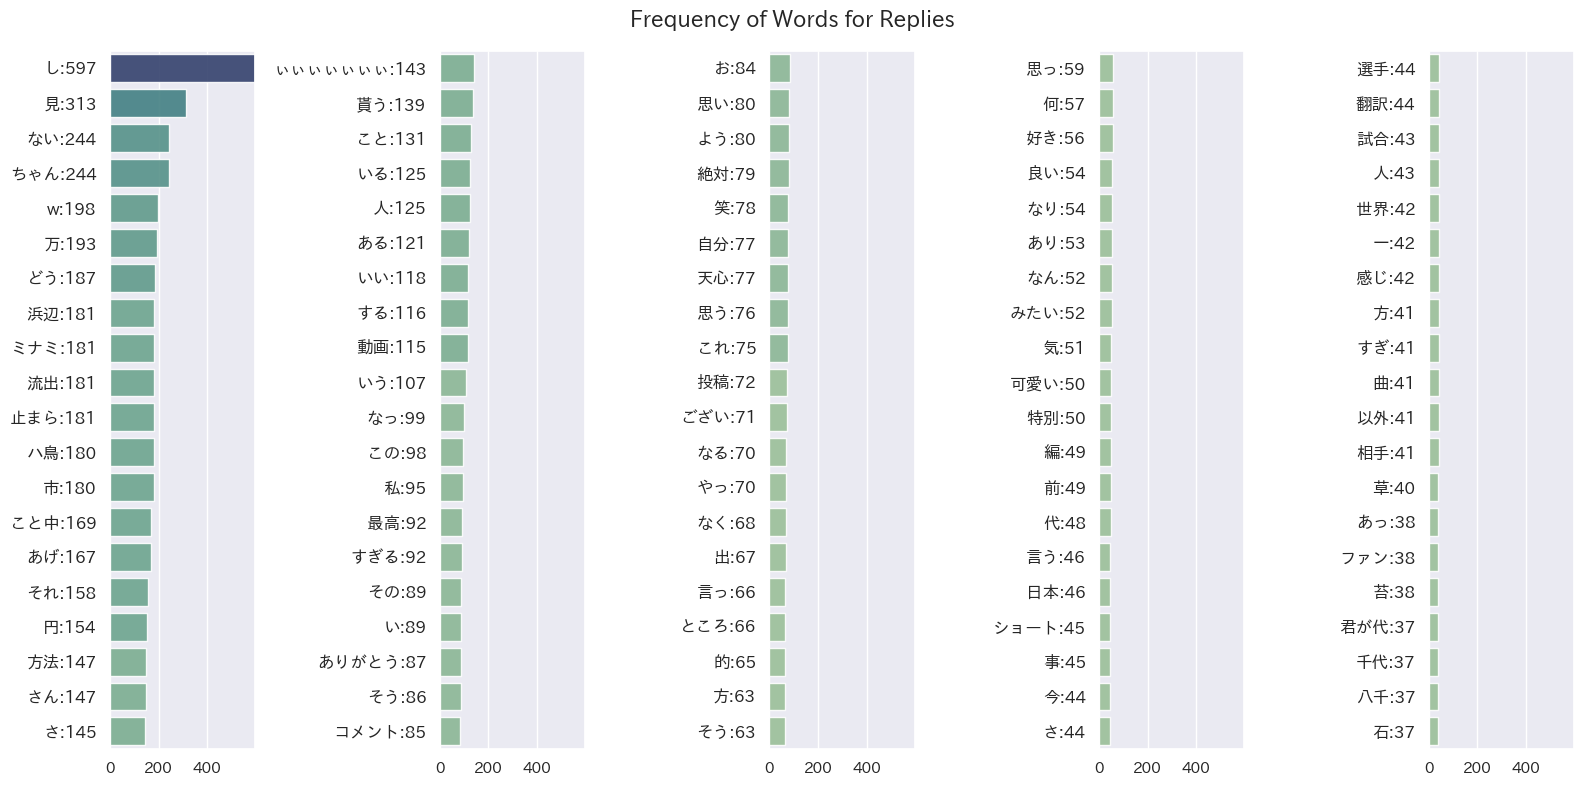

In [97]:
# Generate bar plot
plot_frequency_bars(freq_df, 'Frequency of Words for Replies')

### Notes from this comparison
* Top 10 frequent words very similar for all comments and top-level only; this is mostly unsurprising, as top-level comments make up for 3/4ths of the data.
* Frequency of things like „Åä, „Åï„Çì, „Å°„ÇÉ„Çì in top-level likely arise from talking about/directly to the channel posting the channel as is seen when users refer to the musical artists.
* Six-character repeating half-width „ÅÑ???